In [1]:
import sys
sys.path.append("../")

In [2]:
import pandas as pd
import plotly.graph_objects as go
from technicals.indicators import RSI
from technicals.patterns import apply_patterns
from plotting import CandlePlot
import numpy as np

from infrastructure.quotehistory_collection import quotehistoryCollection as qc

from simulation.donchian_trend_binance import DonchianTrend
from simulation.donchian_reverse_binance import DonchianReverse


In [3]:
from multiprocessing import Process, Manager
import pickle
import warnings
warnings.filterwarnings('ignore')

In [4]:
def run_pair(pair,granularity,ema_1 = 10,donchian_window = 10000, donchian_window_prev = 100, 
             tp=0.01, sl=0.01, donchian_up_signals=[1,3,5,7]):
    df = pd.read_pickle(f"crypto/{pair}_{granularity}.pkl")
    df.reset_index(drop=True, inplace=True)
    df = df.tail(270000)
    
    df[f'EMA_short'] = df.Close.ewm(span=ema_1, min_periods=ema_1).mean()

    df[f'EMA_{ema_1}'] = df.Close.ewm(span=ema_1, min_periods=ema_1).mean()
    
    df['donchian_high'] = df['Close'].rolling(window=donchian_window).max()
    df['donchian_low'] = df['Close'].rolling(window=donchian_window).min()
    df['donchian_mid'] = (df['donchian_high'] + df['donchian_low']) / 2
    df['donchian_75'] = (df['donchian_high'] + df['donchian_mid']) / 2
    df['donchian_87'] = (df['donchian_high'] + df['donchian_75']) / 2
    df['donchian_62'] = (df['donchian_75'] + df['donchian_mid']) / 2
    df['donchian_25'] = (df['donchian_mid'] + df['donchian_low']) / 2
    df['donchian_37'] = (df['donchian_mid'] + df['donchian_25']) / 2
    df['donchian_12'] = (df['donchian_25'] + df['donchian_low']) / 2
    
    df['returns'] = df['Close'].pct_change()
    df["creturns"] = df["returns"].cumsum()

    df["strategy"] = 0
    df["cstrategy"] = 0

    df['time'] = df['Time'].copy()
    
    df_slim = df.copy()
    df_slim.dropna(inplace=True)
    df_slim.reset_index(drop=True, inplace=True)

    gt = DonchianTrend(
        df_slim,
        donchian_window_prev = donchian_window_prev,
        tp=tp,
        sl=sl,
        donchian_up_signals=donchian_up_signals
    )
    
    gt.run_test()
    return gt

In [5]:

pairs_pip_size = ["ADAUSDT","BTCUSDT",'ETHUSDT','BNBUSDT','XRPUSDT','LTCUSDT']

In [6]:
# pairs_pip_size =['BTCUSDT']

In [7]:
def get_list_args():
    args_dic_list = []
    for es in [5,50]:
        for dw in [500,1000,1500,2500]:
            for dwp in [5,50,200]:
                for tp in [0.01,0.02,0.03,0.05]:
                    for sl in [0.1,0.2,0.5]:
                        for donchian_up_signals in [[9]]:
                            if es < dw and dwp < dw:
                                for pair in pairs_pip_size:
                                    for granularity in ['1m']:
                                        args_dic = {"es": es,
                                                    "dw": dw,
                                                    "dwp": dwp,
                                                    "tp": tp, 
                                                    "sl":sl, 
                                                    "pair":pair, 
                                                    "granularity":granularity,
                                                    "donchian_up_signals":donchian_up_signals}
                                        args_dic_list.append(args_dic)

    return args_dic_list

In [8]:


def run_process(L, arg):
    # print("PROCESS",arg)
    L.append(
        dict(
            arg=arg,
            pair=arg['pair'],
            ema_1=arg['es'],
            donchian_window = arg['dw'],
            donchian_window_prev = arg['dwp'],
            tp = arg['tp'],
            sl = arg['sl'],
            res=run_pair(
                pair=arg['pair'],
                granularity=arg['granularity'],
                ema_1=arg['es'],
                donchian_window = arg['dw'],
                donchian_window_prev = arg['dwp'],
                tp = arg['tp'],
                sl = arg['sl'],
                donchian_up_signals= arg['donchian_up_signals']
            )
        )
    )


lista = []
def run_ema_macd():
    with Manager() as manager:
        global lista
        L = manager.list()  # <-- can be shared between processes.
        args_list = get_list_args()
        print(len(args_list))
        limit = 10
        current = 0
    
        while current < len(args_list):
            print(current)
            processes = []
            todo = len(args_list) - current
            if todo < limit:
                limit = todo
    
            for _ in range(limit):
                processes.append(Process(target=run_process, args=(L,args_list[current])))
                current += 1
    
            for p in processes:
                p.start()
    
            for p in processes:
                p.join()

        print("ALL DONE")
        lista = list(L)
        with open(f"./result-binance-trend-limite-compra-percentual-01-apenas-9.pkl", "wb") as f:
            pickle.dump(lista, f)  # Usa o pickle para salvar o arquivo


In [9]:
%%time

run_ema_macd()

1728
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
ALL DONE
CPU times: user 2.23 s, sys: 18 s, total: 20.3 s
Wall time: 11min 23s


In [10]:
# with open(f"./result-binance-trend.pkl", "wb") as f:
#     pickle.dump(lista, f)  # Usa o pickle para salvar o arquivo

In [10]:
# res = lista

with open("./result-binance-trend-sem-limite-max_o-apenas-9.pkl", "rb") as f:
    res = pickle.load(f)

In [11]:
dic_res = []
for r in res:

    if r['res'].len_close > 10:
        signal_up = r['res'].df_results.SIGNAL_UP.values[-1]
        if signal_up == 9:
            res_pos = r['res'].df_results[r['res'].df_results['result'] > 0]
            res_neg = r['res'].df_results[r['res'].df_results['result'] < 0]
            sum_neg = res_neg.result.sum() * -1
            sum_pos = res_pos.result.sum()
            
            res_pos_s = r['res'].df_results[r['res'].df_results['strategy'] > 0]
            res_neg_s = r['res'].df_results[r['res'].df_results['strategy'] < 0]
            sum_neg_s = res_neg_s.strategy.sum() *-1
            sum_pos_s = res_pos_s.strategy.sum()
            dic_res.append(
                dict(
                    pair = r['pair'],
                    ema = r['ema_1'],
                    strat = round(r['res'].df_results.strategy.sum(),3),
                    res = round(r['res'].df_results.result.sum(),3),
                    sig = signal_up,
                    c = r['res'].df_results['count'].mean(),
                    tp = r['tp'],
                    sl = r['res'].df_results.sl.values[-1],
                    dw = r['donchian_window'],
                    dwp = r['donchian_window_prev'],
                    max_o = max(r['res'].df_results.total_opened),
    
                    
                    s_p_s = sum_pos_s,
                    s_n_s = sum_neg_s,
                    Rel_sum = sum_pos_s/(sum_pos_s+ sum_neg_s),
                    
                    l_p_s = len(res_pos_s),
                    l_n_s = len(res_neg_s),
                    Rel_len = len(res_pos_s)/(len(res_pos_s)+ len(res_neg_s)),
                    
                    l_c = r['res'].len_close,
                    l_o = r['res'].len_open,
                       
                    # l_p = len(res_pos),
                    # l_n = len(res_neg),
                    # sum_pos = sum_pos,
                    # sum_neg = sum_neg,
                    # Rel_len_pos_neg = len(res_pos)/(len(res_pos)+ len(res_neg)),
                    # Rel_pos_neg = sum_pos/(sum_pos+ sum_neg),
    
                    first_p = r['res'].first_price,
                    last_p = r['res'].last_price,
                    r = r['res'].df_results
                )
    )
    # print(f"p={p}  e={e}  dw={dw}  dwp={dwp}   strategy={st}   result={result}")


In [12]:
df_res = pd.DataFrame(dic_res)

In [13]:
df_res.tail()

,pair,ema,strat,res,sig,c,tp,sl,dw,dwp,...,s_n_s,Rel_sum,l_p_s,l_n_s,Rel_len,l_c,l_o,first_p,last_p,r
1075,BNBUSDT,50,5.876,2798.20,9,23240.539683,0.05,0.5,1500,200,...,0.510592,0.925975,125,1,0.992063,126,10,584.6000,567.4000,running start_index_m5 count trigger_...
1076,BTCUSDT,50,6.003,340124.98,9,18988.033898,0.05,0.5,1500,200,...,-0.000000,1.000000,118,0,1.000000,118,14,70839.1600,63327.5900,running start_index_m5 count trigger_t...
1077,ADAUSDT,50,0.404,-0.84,9,26975.981366,0.05,0.5,1500,200,...,7.088688,0.513842,147,14,0.913043,161,8,0.6488,0.3733,running start_index_m5 count trigger_t...
1078,ETHUSDT,50,-0.092,-1985.39,9,20113.727273,0.05,0.5,1500,200,...,4.801996,0.495151,89,10,0.898990,99,35,3576.7800,2602.2300,running start_index_m5 count trigger_ty...
1079,LTCUSDT,50,3.042,154.67,9,19649.350877,0.05,0.5,1500,200,...,2.479046,0.690106,109,5,0.956140,114,30,95.4000,66.8200,running start_index_m5 count trigger_t...


In [14]:
df_res.describe()

,ema,strat,res,sig,c,tp,sl,dw,dwp,max_o,s_p_s,s_n_s,Rel_sum,l_p_s,l_n_s,Rel_len,l_c,l_o,first_p,last_p
count,1080.000000,1080.000000,1.080000e+03,1080.0,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000
mean,23.000000,-0.491179,2.426051e+04,9.0,8621.879919,0.027500,0.266667,1000.000000,101.000000,54.908333,10.064259,10.555449,0.534025,368.468519,66.108333,0.849494,434.576852,17.612037,12343.554978,11094.170783
std,22.055621,8.080418,2.138637e+05,0.0,5853.896441,0.014797,0.170046,408.437426,82.524577,44.009140,7.905350,10.608243,0.209895,220.713156,75.535005,0.129705,251.380654,23.832293,25762.183831,23388.162373
min,5.000000,-36.887000,-1.327758e+06,9.0,1034.053719,0.010000,0.100000,500.000000,5.000000,7.000000,1.155311,-0.000000,0.264814,64.000000,0.000000,0.493976,99.000000,1.000000,0.612400,0.373300
25%,5.000000,-4.094000,-2.793840e+03,9.0,4337.030634,0.017500,0.100000,500.000000,50.000000,25.000000,4.461063,3.030637,0.384681,183.000000,11.000000,0.749381,217.000000,6.000000,0.647400,0.611400
50%,5.000000,-1.388500,-2.412500e+00,9.0,7122.972063,0.025000,0.200000,1000.000000,50.000000,41.000000,7.657269,7.455183,0.449189,327.000000,42.000000,0.875348,377.000000,11.000000,333.740000,317.110000
75%,50.000000,1.840250,5.402250e+00,9.0,11701.336871,0.035000,0.500000,1500.000000,200.000000,70.000000,13.318670,14.878524,0.600411,485.250000,91.250000,0.965735,600.250000,19.000000,3513.770000,2602.230000
max,50.000000,52.830000,2.492314e+06,9.0,29030.347534,0.050000,0.500000,1500.000000,200.000000,332.000000,54.234355,75.806804,1.000000,1212.000000,471.000000,1.000000,1242.000000,261.000000,70839.160000,63327.590000


In [15]:
df_sorted_desc = df_res.sort_values(by=['pair','strat'], ascending=False)

In [16]:
# Exibir todas as linhas
pd.set_option('display.max_rows', None)

df_sorted_desc.head()

,pair,ema,strat,res,sig,c,tp,sl,dw,dwp,...,s_n_s,Rel_sum,l_p_s,l_n_s,Rel_len,l_c,l_o,first_p,last_p,r
78,XRPUSDT,5,52.830,23.202,9,23849.862376,0.05,0.5,500,5,...,-0.0,1.0,1010,0,1.0,1010,14,0.6149,0.6114,running start_index_m5 count trigger...
146,XRPUSDT,5,36.678,16.106,9,25075.211048,0.05,0.5,500,50,...,-0.0,1.0,706,0,1.0,706,9,0.6149,0.6114,running start_index_m5 count trigger_...
214,XRPUSDT,5,33.504,14.775,9,25720.508501,0.05,0.5,500,200,...,-0.0,1.0,647,0,1.0,647,5,0.6149,0.6114,running start_index_m5 count trigger_...
284,XRPUSDT,5,32.949,14.508,9,22782.748006,0.05,0.5,1000,5,...,-0.0,1.0,627,0,1.0,627,13,0.6124,0.6114,running start_index_m5 count trigger_...
56,XRPUSDT,5,32.763,14.343,9,14725.058416,0.03,0.5,500,5,...,-0.0,1.0,1010,0,1.0,1010,14,0.6149,0.6114,running start_index_m5 count trigger...


In [17]:
def rank_backtest_results(df):
    # Definindo pesos para cada coluna com base na importância
    weights = {
        'strat': 0.4,           # Retorno acumulado percentual (maximizar)
        'Rel_len': 0.1,      # Relação de trades positivos/negativos (maximizar)
        'Rel_sum': 0.1,        # Relação de resultados positivos/negativos (maximizar)
        'l_p_s': 0.1,            # Quantidade de trades positivos (maximizar)
        'l_n_s': -0.1,           # Quantidade de trades negativos (minimizar)
        's_p_s': 0.05,           # Soma dos retornos positivos (maximizar)
        's_n_s': -0.05,          # Soma dos retornos negativos (minimizar)
        'c': -0.05,          # Média de candles até TP ou SL (minimizar)
        'max_o': -0.1,       # Máximo de operações abertas ao mesmo tempo (minimizar)
        # 'ema': -0.01,            # EMA short (minimizar)
        # 'tp': 0.1,             # Take profit percentual (minimizar)
        # 'sl': -0.05,             # Stop loss percentual (minimizar)
        # 'dw': -0.01              # Janela Donchian (minimizar)
    }
    
    # Normalizando as colunas relevantes
    for col in weights.keys():
        df[col + '_norm'] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    
    # Calculando o score ponderado para cada linha
    df['score'] = sum(
        df[col + '_norm'] * weight if weight >= 0 else (1 - df[col + '_norm']) * abs(weight) 
        for col, weight in weights.items()
    )
    
    # Ordenando o DataFrame pelos melhores resultados com base no score
    df_sorted = df.sort_values(by='score', ascending=False).reset_index(drop=True)
    
    # Removendo colunas de normalização temporárias
    df_sorted.drop(columns=[col + '_norm' for col in weights.keys()], inplace=True)
    
    return df_sorted

In [18]:
df_ADAUSDT = df_res[df_res['pair']=='ADAUSDT']
df_BTCUSDT = df_res[df_res['pair']=='BTCUSDT']
df_ETHUSDT = df_res[df_res['pair']=='ETHUSDT']
df_BNBUSDT = df_res[df_res['pair']=='BNBUSDT']
df_XRPUSDT = df_res[df_res['pair']=='XRPUSDT']
df_LTCUSDT = df_res[df_res['pair']=='LTCUSDT']

In [19]:
df_ADAUSDT.columns

Index(['pair', 'ema', 'strat', 'res', 'sig', 'c', 'tp', 'sl', 'dw', 'dwp',
       'max_o', 's_p_s', 's_n_s', 'Rel_sum', 'l_p_s', 'l_n_s', 'Rel_len',
       'l_c', 'l_o', 'first_p', 'last_p', 'r'],
      dtype='object')

In [20]:
rank_ADAUSDT = rank_backtest_results(df_ADAUSDT)
rank_BTCUSDT = rank_backtest_results(df_BTCUSDT)
rank_ETHUSDT = rank_backtest_results(df_ETHUSDT)
rank_BNBUSDT = rank_backtest_results(df_BNBUSDT)
rank_XRPUSDT = rank_backtest_results(df_XRPUSDT)
rank_LTCUSDT = rank_backtest_results(df_LTCUSDT)

In [21]:
rank_ADAUSDT[['pair', 'ema', 'strat', 'res', 'sig', 'c', 'tp', 'sl', 'dw', 'dwp',
       'max_o', 's_p_s', 's_n_s', 'Rel_sum', 'l_p_s', 'l_n_s']].head(10)

,pair,ema,strat,res,sig,c,tp,sl,dw,dwp,max_o,s_p_s,s_n_s,Rel_sum,l_p_s,l_n_s
0,ADAUSDT,50,1.255,0.356,9,1778.479339,0.01,0.2,1000,50,10,2.568066,1.312948,0.661700,236,6
1,ADAUSDT,5,1.075,-0.776,9,5175.348538,0.01,0.5,500,50,49,9.177015,8.102261,0.531100,838,17
2,ADAUSDT,5,1.058,-0.118,9,2039.445378,0.01,0.2,1500,5,25,6.258304,5.200058,0.546178,569,26
3,ADAUSDT,50,0.964,-0.095,9,4959.603261,0.01,0.5,500,50,18,3.973098,3.008669,0.569068,362,6
4,ADAUSDT,50,0.681,0.075,9,1995.085106,0.01,0.2,1500,50,8,1.987063,1.305975,0.603413,182,6
5,ADAUSDT,50,0.835,0.275,9,1034.053719,0.01,0.1,1000,50,9,2.467858,1.633058,0.601782,227,15
6,ADAUSDT,50,0.585,-0.059,9,4350.483471,0.01,0.5,1000,50,12,2.590405,2.005848,0.563591,238,4
7,ADAUSDT,5,-1.098,-1.225,9,1972.774557,0.01,0.2,500,5,37,12.834581,13.932087,0.479499,1173,69
8,ADAUSDT,5,0.050,-0.417,9,2127.009357,0.01,0.2,500,50,36,8.885253,8.835601,0.501401,811,44
9,ADAUSDT,5,2.599,-0.722,9,13764.289044,0.03,0.5,1500,50,52,12.630183,10.031343,0.557340,409,20


In [22]:
rank_BTCUSDT[['pair', 'ema', 'strat', 'res', 'sig', 'c', 'tp', 'sl', 'dw', 'dwp',
       'max_o', 's_p_s', 's_n_s', 'Rel_sum', 'l_p_s', 'l_n_s']].head(10)

,pair,ema,strat,res,sig,c,tp,sl,dw,dwp,max_o,s_p_s,s_n_s,Rel_sum,l_p_s,l_n_s
0,BTCUSDT,5,44.045,2492314.40,9,19718.986159,0.05,0.5,500,5,253,44.045121,-0.0,1.0,867,0
1,BTCUSDT,5,29.289,1618758.66,9,13520.644211,0.03,0.5,500,5,169,29.289433,-0.0,1.0,950,0
2,BTCUSDT,5,20.279,1088547.16,9,10744.598555,0.02,0.5,500,5,131,20.279437,-0.0,1.0,969,0
3,BTCUSDT,5,31.240,1792474.37,9,19295.641234,0.05,0.5,500,50,187,31.240457,-0.0,1.0,616,0
4,BTCUSDT,5,29.113,1633295.52,9,20241.970332,0.05,0.5,1000,5,151,29.113118,-0.0,1.0,573,0
5,BTCUSDT,5,28.570,1650544.20,9,19054.494681,0.05,0.5,500,200,177,28.570489,-0.0,1.0,564,0
6,BTCUSDT,5,20.951,1185299.06,9,13032.032305,0.03,0.5,500,50,111,20.950542,-0.0,1.0,681,0
7,BTCUSDT,5,10.660,574526.89,9,5334.967380,0.01,0.5,500,5,71,10.660428,-0.0,1.0,981,0
8,BTCUSDT,5,19.540,1106940.12,9,13604.627172,0.03,0.5,500,200,101,19.540032,-0.0,1.0,633,0
9,BTCUSDT,5,18.633,1027947.97,9,13001.241722,0.03,0.5,1000,5,105,18.633457,-0.0,1.0,604,0


In [23]:
rank_ETHUSDT[['pair', 'ema', 'strat', 'res', 'sig', 'c', 'tp', 'sl', 'dw', 'dwp',
       'max_o', 's_p_s', 's_n_s', 'Rel_sum', 'l_p_s', 'l_n_s']].head(10)

,pair,ema,strat,res,sig,c,tp,sl,dw,dwp,max_o,s_p_s,s_n_s,Rel_sum,l_p_s,l_n_s
0,ETHUSDT,5,4.282,9827.46,9,4713.967213,0.01,0.5,1500,5,43,5.258007,0.976418,0.843383,486,2
1,ETHUSDT,5,3.085,7862.37,9,4075.309091,0.01,0.5,1500,200,34,3.566315,0.481737,0.880995,329,1
2,ETHUSDT,5,2.668,1941.44,9,5482.579882,0.01,0.5,500,5,88,10.827495,8.159738,0.570251,997,17
3,ETHUSDT,5,2.968,6841.93,9,4954.312329,0.01,0.5,1500,50,37,3.947678,0.980127,0.801103,363,2
4,ETHUSDT,50,2.047,4143.20,9,5577.764706,0.01,0.5,500,50,33,3.497112,1.450399,0.706843,320,3
5,ETHUSDT,5,1.769,1186.27,9,5704.680578,0.01,0.5,1000,5,55,6.628644,4.859283,0.577010,613,10
6,ETHUSDT,50,1.428,3064.21,9,5926.058480,0.01,0.5,1500,50,19,1.896153,0.468007,0.802041,170,1
7,ETHUSDT,5,4.470,8502.27,9,12317.123832,0.03,0.5,1500,5,102,13.044324,8.574193,0.603387,410,18
8,ETHUSDT,5,2.889,5887.27,9,9239.023256,0.02,0.5,1500,50,62,7.121284,4.232256,0.627230,335,9
9,ETHUSDT,50,0.916,2121.37,9,4749.435484,0.01,0.5,1500,200,15,1.384480,0.468007,0.747363,123,1


In [24]:
rank_BNBUSDT[['pair', 'ema', 'strat', 'res', 'sig', 'c', 'tp', 'sl', 'dw', 'dwp',
       'max_o', 's_p_s', 's_n_s', 'Rel_sum', 'l_p_s', 'l_n_s']].head(10)

,pair,ema,strat,res,sig,c,tp,sl,dw,dwp,max_o,s_p_s,s_n_s,Rel_sum,l_p_s,l_n_s
0,BNBUSDT,5,45.690,20894.2,9,25859.579048,0.05,0.5,500,5,232,52.865747,7.175265,0.880494,1036,14
1,BNBUSDT,5,27.467,12329.9,9,15420.551270,0.03,0.5,500,5,187,32.629443,5.162007,0.863408,1053,10
2,BNBUSDT,5,29.107,13464.6,9,26748.341049,0.05,0.5,500,50,151,32.717593,3.610782,0.900607,641,7
3,BNBUSDT,5,28.818,13261.8,9,24489.093514,0.05,0.5,1000,5,172,33.384953,4.566920,0.879665,654,9
4,BNBUSDT,5,17.027,7496.7,9,9964.606343,0.02,0.5,500,5,144,22.188723,5.162007,0.811266,1062,10
5,BNBUSDT,5,25.900,11729.4,9,28859.334471,0.05,0.5,500,200,144,29.494520,3.594945,0.891357,579,7
6,BNBUSDT,5,9.123,4071.5,9,4710.454963,0.01,0.5,500,5,83,11.674823,2.551929,0.820625,1083,5
7,BNBUSDT,5,23.133,10655.4,9,24375.663386,0.05,0.5,1500,5,139,25.684917,2.551929,0.909624,503,5
8,BNBUSDT,5,18.176,8305.8,9,14765.867953,0.03,0.5,1000,5,134,20.727904,2.551929,0.890380,669,5
9,BNBUSDT,5,16.299,7428.7,9,16446.757983,0.03,0.5,500,200,99,18.364091,2.064976,0.898920,591,4


In [25]:
rank_XRPUSDT[['pair', 'ema', 'strat', 'res', 'sig', 'c', 'tp', 'sl', 'dw', 'dwp',
       'max_o', 's_p_s', 's_n_s', 'Rel_sum', 'l_p_s', 'l_n_s']].head(10)

,pair,ema,strat,res,sig,c,tp,sl,dw,dwp,max_o,s_p_s,s_n_s,Rel_sum,l_p_s,l_n_s
0,XRPUSDT,5,52.830,23.202,9,23849.862376,0.05,0.5,500,5,307,52.830006,-0.000000,1.000000,1010,0
1,XRPUSDT,5,32.763,14.343,9,14725.058416,0.03,0.5,500,5,192,32.762749,-0.000000,1.000000,1010,0
2,XRPUSDT,5,36.678,16.106,9,25075.211048,0.05,0.5,500,50,232,36.678139,-0.000000,1.000000,706,0
3,XRPUSDT,5,22.510,9.667,9,10356.975272,0.02,0.5,500,5,136,22.509801,-0.000000,1.000000,1011,0
4,XRPUSDT,5,32.949,14.508,9,22782.748006,0.05,0.5,1000,5,190,32.949492,-0.000000,1.000000,627,0
5,XRPUSDT,5,33.504,14.775,9,25720.508501,0.05,0.5,500,200,208,33.503705,-0.000000,1.000000,647,0
6,XRPUSDT,5,23.048,10.349,9,14771.273371,0.03,0.5,500,50,141,23.047602,-0.000000,1.000000,706,0
7,XRPUSDT,5,11.576,4.786,9,5558.889546,0.01,0.5,500,5,77,11.579399,0.003158,0.999727,1011,3
8,XRPUSDT,5,21.207,9.515,9,15349.806801,0.03,0.5,500,200,127,21.207130,-0.000000,1.000000,647,0
9,XRPUSDT,5,24.570,11.159,9,19293.881466,0.05,0.5,1500,5,137,24.570103,-0.000000,1.000000,464,0


In [26]:
rank_LTCUSDT[['pair', 'ema', 'strat', 'res', 'sig', 'c', 'tp', 'sl', 'dw', 'dwp',
       'max_o', 's_p_s', 's_n_s', 'Rel_sum', 'l_p_s', 'l_n_s']].head(10)

,pair,ema,strat,res,sig,c,tp,sl,dw,dwp,max_o,s_p_s,s_n_s,Rel_sum,l_p_s,l_n_s
0,LTCUSDT,5,13.759,777.63,9,11364.174716,0.03,0.5,500,50,152,21.250134,7.491467,0.739351,689,15
1,LTCUSDT,5,14.035,673.18,9,12606.681637,0.03,0.5,500,5,228,30.067852,16.032906,0.652220,970,32
2,LTCUSDT,5,8.828,480.30,9,7770.908725,0.02,0.5,500,50,99,15.317240,6.489513,0.702408,732,13
3,LTCUSDT,5,9.199,554.20,9,10290.252983,0.03,0.5,1000,50,89,12.691742,3.492702,0.784194,412,7
4,LTCUSDT,5,9.002,560.94,9,9687.340369,0.03,0.5,1000,200,109,11.496609,2.494654,0.821699,374,5
5,LTCUSDT,5,3.569,208.87,9,3756.418269,0.01,0.5,1000,200,55,4.542010,0.972567,0.823637,414,2
6,LTCUSDT,5,6.683,204.59,9,9407.952199,0.02,0.5,500,5,170,21.223990,14.541125,0.593427,1017,29
7,LTCUSDT,5,3.433,127.88,9,4688.987179,0.01,0.5,500,50,60,8.402456,4.969201,0.628378,769,11
8,LTCUSDT,5,9.407,516.38,9,11482.661348,0.03,0.5,500,200,143,16.935771,7.529141,0.692247,549,15
9,LTCUSDT,5,15.112,715.19,9,19945.995327,0.05,0.5,500,50,245,30.989078,15.876585,0.661232,610,32


In [33]:
def rank_tests(df, total_investment):
    # Calcula o capital fracionado para cada teste com base em max_o
    df['capital_fracionado'] = total_investment / df['max_o']
    
    # Calcula o retorno total ajustado, considerando o capital fracionado e o retorno percentual (strat)
    df['retorno_ajustado'] = df['capital_fracionado'] * df['strat']
    
    # Ordena o DataFrame pelo retorno ajustado em ordem decrescente
    ranked_df = df.sort_values(by='retorno_ajustado', ascending=False).reset_index(drop=True)
    
    return ranked_df

In [34]:
total_investment = 5000
df_inv = rank_tests(rank_ADAUSDT, total_investment)
df_inv[['pair', 'ema', 'strat', 'res', 'sig', 'c', 'tp', 'sl', 'dw', 'dwp',
       'max_o', 's_p_s', 's_n_s', 'Rel_sum', 'l_p_s', 'l_n_s','capital_fracionado','retorno_ajustado']].head(10)

,pair,ema,strat,res,sig,c,tp,sl,dw,dwp,max_o,s_p_s,s_n_s,Rel_sum,l_p_s,l_n_s,capital_fracionado,retorno_ajustado
0,ADAUSDT,50,1.255,0.356,9,1778.479339,0.01,0.2,1000,50,10,2.568066,1.312948,0.661700,236,6,500.000000,627.500000
1,ADAUSDT,50,0.835,0.275,9,1034.053719,0.01,0.1,1000,50,9,2.467858,1.633058,0.601782,227,15,555.555556,463.888889
2,ADAUSDT,50,0.681,0.075,9,1995.085106,0.01,0.2,1500,50,8,1.987063,1.305975,0.603413,182,6,625.000000,425.625000
3,ADAUSDT,50,1.875,-0.079,9,13942.534188,0.03,0.5,1000,50,25,6.910372,5.035610,0.578468,224,10,200.000000,375.000000
4,ADAUSDT,50,1.346,-0.221,9,15139.884615,0.03,0.5,1500,50,22,5.353517,4.007647,0.571886,174,8,227.272727,305.909091
5,ADAUSDT,50,1.291,-0.125,9,15421.251534,0.03,0.5,1500,200,22,4.810927,3.519740,0.577496,156,7,227.272727,293.409091
6,ADAUSDT,5,4.448,-0.907,9,23016.775943,0.05,0.5,1500,50,77,20.038711,15.590669,0.562421,393,31,64.935065,288.831169
7,ADAUSDT,50,0.964,-0.095,9,4959.603261,0.01,0.5,500,50,18,3.973098,3.008669,0.569068,362,6,277.777778,267.777778
8,ADAUSDT,50,1.325,-0.155,9,14279.085427,0.03,0.5,1000,200,26,5.877115,4.552442,0.563506,190,9,192.307692,254.807692
9,ADAUSDT,5,2.599,-0.722,9,13764.289044,0.03,0.5,1500,50,52,12.630183,10.031343,0.557340,409,20,96.153846,249.903846


In [35]:
total_investment = 5000
df_inv = rank_tests(rank_BTCUSDT, total_investment)
df_inv[['pair', 'ema', 'strat', 'res', 'sig', 'c', 'tp', 'sl', 'dw', 'dwp',
       'max_o', 's_p_s', 's_n_s', 'Rel_sum', 'l_p_s', 'l_n_s','capital_fracionado','retorno_ajustado']].head(10)

,pair,ema,strat,res,sig,c,tp,sl,dw,dwp,max_o,s_p_s,s_n_s,Rel_sum,l_p_s,l_n_s,capital_fracionado,retorno_ajustado
0,BTCUSDT,50,8.052,451410.37,9,19150.803797,0.05,0.5,1500,50,37,8.051703,-0.0,1.0,158,0,135.135135,1088.108108
1,BTCUSDT,5,18.006,1026563.68,9,18417.823034,0.05,0.5,1500,50,85,18.006328,-0.0,1.0,356,0,58.823529,1059.176471
2,BTCUSDT,50,10.488,592916.76,9,18302.883495,0.05,0.5,1000,50,51,10.488364,-0.0,1.0,206,0,98.039216,1028.235294
3,BTCUSDT,5,23.286,1303247.27,9,19680.395197,0.05,0.5,1500,5,114,23.285807,-0.0,1.0,458,0,43.859649,1021.315789
4,BTCUSDT,5,14.443,813478.39,9,12887.777778,0.03,0.5,1000,50,72,14.443245,-0.0,1.0,468,0,69.444444,1002.986111
5,BTCUSDT,5,11.536,647169.78,9,12200.072386,0.03,0.5,1500,50,58,11.536387,-0.0,1.0,373,0,86.206897,994.482759
6,BTCUSDT,50,7.690,435124.28,9,21139.278146,0.05,0.5,1000,200,39,7.689950,-0.0,1.0,151,0,128.205128,985.897436
7,BTCUSDT,5,19.540,1106940.12,9,13604.627172,0.03,0.5,500,200,101,19.540032,-0.0,1.0,633,0,49.504950,967.326733
8,BTCUSDT,5,29.113,1633295.52,9,20241.970332,0.05,0.5,1000,5,151,29.113118,-0.0,1.0,573,0,33.112583,964.006623
9,BTCUSDT,5,20.951,1185299.06,9,13032.032305,0.03,0.5,500,50,111,20.950542,-0.0,1.0,681,0,45.045045,943.738739


In [36]:
total_investment = 5000
df_inv = rank_tests(rank_ETHUSDT, total_investment)
df_inv[['pair', 'ema', 'strat', 'res', 'sig', 'c', 'tp', 'sl', 'dw', 'dwp',
       'max_o', 's_p_s', 's_n_s', 'Rel_sum', 'l_p_s', 'l_n_s','capital_fracionado','retorno_ajustado']].head(10)

,pair,ema,strat,res,sig,c,tp,sl,dw,dwp,max_o,s_p_s,s_n_s,Rel_sum,l_p_s,l_n_s,capital_fracionado,retorno_ajustado
0,ETHUSDT,5,4.282,9827.46,9,4713.967213,0.01,0.5,1500,5,43,5.258007,0.976418,0.843383,486,2,116.279070,497.906977
1,ETHUSDT,50,1.867,4448.38,9,8478.803797,0.02,0.5,1000,200,20,3.312450,1.445912,0.696132,155,3,250.000000,466.750000
2,ETHUSDT,5,3.085,7862.37,9,4075.309091,0.01,0.5,1500,200,34,3.566315,0.481737,0.880995,329,1,147.058824,453.676471
3,ETHUSDT,5,2.968,6841.93,9,4954.312329,0.01,0.5,1500,50,37,3.947678,0.980127,0.801103,363,2,135.135135,401.081081
4,ETHUSDT,50,1.428,3064.21,9,5926.058480,0.01,0.5,1500,50,19,1.896153,0.468007,0.802041,170,1,263.157895,375.789474
5,ETHUSDT,50,1.972,3999.31,9,12512.286624,0.03,0.5,1500,50,30,4.794719,2.822676,0.629443,151,6,166.666667,328.666667
6,ETHUSDT,50,2.047,4143.20,9,5577.764706,0.01,0.5,500,50,33,3.497112,1.450399,0.706843,320,3,151.515152,310.151515
7,ETHUSDT,50,1.538,3584.71,9,11123.513274,0.03,0.5,1500,200,25,3.452091,1.913794,0.643340,109,4,200.000000,307.600000
8,ETHUSDT,50,0.916,2121.37,9,4749.435484,0.01,0.5,1500,200,15,1.384480,0.468007,0.747363,123,1,333.333333,305.333333
9,ETHUSDT,50,1.271,2438.66,9,5972.111650,0.01,0.5,1000,50,24,2.258498,0.987483,0.695783,204,2,208.333333,264.791667


In [37]:
total_investment = 5000
df_inv = rank_tests(rank_BNBUSDT, total_investment)
df_inv[['pair', 'ema', 'strat', 'res', 'sig', 'c', 'tp', 'sl', 'dw', 'dwp',
       'max_o', 's_p_s', 's_n_s', 'Rel_sum', 'l_p_s', 'l_n_s','capital_fracionado','retorno_ajustado']].head(10)

,pair,ema,strat,res,sig,c,tp,sl,dw,dwp,max_o,s_p_s,s_n_s,Rel_sum,l_p_s,l_n_s,capital_fracionado,retorno_ajustado
0,BNBUSDT,5,45.690,20894.2,9,25859.579048,0.05,0.5,500,5,232,52.865747,7.175265,0.880494,1036,14,21.551724,984.698276
1,BNBUSDT,5,29.107,13464.6,9,26748.341049,0.05,0.5,500,50,151,32.717593,3.610782,0.900607,641,7,33.112583,963.807947
2,BNBUSDT,50,14.322,6549.0,9,25802.935583,0.05,0.5,500,50,76,16.363336,2.041042,0.889100,322,4,65.789474,942.236842
3,BNBUSDT,5,25.900,11729.4,9,28859.334471,0.05,0.5,500,200,144,29.494520,3.594945,0.891357,579,7,34.722222,899.305556
4,BNBUSDT,5,19.929,9089.9,9,26810.651685,0.05,0.5,1000,50,112,22.502654,2.573696,0.897366,440,5,44.642857,889.687500
5,BNBUSDT,50,8.155,3833.4,9,24595.274854,0.05,0.5,1000,200,48,8.665625,0.510592,0.944357,170,1,104.166667,849.479167
6,BNBUSDT,50,9.148,4232.5,9,23339.568075,0.05,0.5,1000,50,54,10.665230,1.517670,0.875426,210,3,92.592593,847.037037
7,BNBUSDT,5,15.443,6997.7,9,27345.755224,0.05,0.5,1500,50,92,16.985001,1.542352,0.916753,332,3,54.347826,839.293478
8,BNBUSDT,5,28.818,13261.8,9,24489.093514,0.05,0.5,1000,5,172,33.384953,4.566920,0.879665,654,9,29.069767,837.732558
9,BNBUSDT,5,23.133,10655.4,9,24375.663386,0.05,0.5,1500,5,139,25.684917,2.551929,0.909624,503,5,35.971223,832.122302


In [38]:
total_investment = 5000
df_inv = rank_tests(rank_XRPUSDT, total_investment)
df_inv[['pair', 'ema', 'strat', 'res', 'sig', 'c', 'tp', 'sl', 'dw', 'dwp',
       'max_o', 's_p_s', 's_n_s', 'Rel_sum', 'l_p_s', 'l_n_s','capital_fracionado','retorno_ajustado']].head(10)

,pair,ema,strat,res,sig,c,tp,sl,dw,dwp,max_o,s_p_s,s_n_s,Rel_sum,l_p_s,l_n_s,capital_fracionado,retorno_ajustado
0,XRPUSDT,50,8.555,3.999,9,16833.515723,0.05,0.5,1500,50,41,8.554799,-0.0,1.0,159,0,121.951220,1043.292683
1,XRPUSDT,50,2.021,0.951,9,3398.765363,0.01,0.5,1000,200,10,2.020852,-0.0,1.0,179,0,500.000000,1010.500000
2,XRPUSDT,50,3.565,1.608,9,7868.937107,0.02,0.5,1500,50,19,3.564576,-0.0,1.0,159,0,263.157895,938.157895
3,XRPUSDT,50,5.179,2.379,9,11286.270440,0.03,0.5,1500,50,28,5.178759,-0.0,1.0,159,0,178.571429,924.821429
4,XRPUSDT,50,16.820,7.557,9,21708.178125,0.05,0.5,500,50,93,16.819819,-0.0,1.0,320,0,53.763441,904.301075
5,XRPUSDT,5,24.570,11.159,9,19293.881466,0.05,0.5,1500,5,137,24.570103,-0.0,1.0,464,0,36.496350,896.715328
6,XRPUSDT,50,8.258,3.726,9,15258.320158,0.03,0.5,500,200,47,8.257642,-0.0,1.0,253,0,106.382979,878.510638
7,XRPUSDT,5,32.949,14.508,9,22782.748006,0.05,0.5,1000,5,190,32.949492,-0.0,1.0,627,0,26.315789,867.078947
8,XRPUSDT,50,5.896,2.706,9,13205.821229,0.03,0.5,1000,200,34,5.896403,-0.0,1.0,179,0,147.058824,867.058824
9,XRPUSDT,50,7.246,3.166,9,9981.978125,0.02,0.5,500,50,42,7.245503,-0.0,1.0,320,0,119.047619,862.619048


In [39]:
total_investment = 5000
df_inv = rank_tests(rank_LTCUSDT, total_investment)
df_inv[['pair', 'ema', 'strat', 'res', 'sig', 'c', 'tp', 'sl', 'dw', 'dwp',
       'max_o', 's_p_s', 's_n_s', 'Rel_sum', 'l_p_s', 'l_n_s','capital_fracionado','retorno_ajustado']].head(10)

,pair,ema,strat,res,sig,c,tp,sl,dw,dwp,max_o,s_p_s,s_n_s,Rel_sum,l_p_s,l_n_s,capital_fracionado,retorno_ajustado
0,LTCUSDT,5,9.199,554.20,9,10290.252983,0.03,0.5,1000,50,89,12.691742,3.492702,0.784194,412,7,56.179775,516.797753
1,LTCUSDT,5,6.949,406.98,9,10761.392097,0.03,0.5,1500,50,72,9.945916,2.996981,0.768446,323,6,69.444444,482.569444
2,LTCUSDT,5,13.759,777.63,9,11364.174716,0.03,0.5,500,50,152,21.250134,7.491467,0.739351,689,15,32.894737,452.598684
3,LTCUSDT,5,8.828,480.30,9,7770.908725,0.02,0.5,500,50,99,15.317240,6.489513,0.702408,732,13,50.505051,445.858586
4,LTCUSDT,50,2.429,129.91,9,12749.533784,0.03,0.5,1500,50,28,4.460246,2.031373,0.687078,144,4,178.571429,433.750000
5,LTCUSDT,50,4.888,266.85,9,12182.643312,0.03,0.5,500,50,57,9.408969,4.521042,0.675446,305,9,87.719298,428.771930
6,LTCUSDT,5,9.913,574.07,9,17570.302632,0.05,0.5,1500,50,116,14.895661,4.982219,0.749359,294,10,43.103448,427.284483
7,LTCUSDT,5,5.584,306.91,9,8002.891892,0.02,0.5,1000,50,67,9.076542,3.492702,0.722123,437,7,74.626866,416.716418
8,LTCUSDT,5,9.002,560.94,9,9687.340369,0.03,0.5,1000,200,109,11.496609,2.494654,0.821699,374,5,45.871560,412.935780
9,LTCUSDT,50,2.300,128.57,9,11084.650794,0.03,0.5,1500,200,29,3.798852,1.499199,0.717028,123,3,172.413793,396.551724


In [151]:
# df_results = res[108]['res'].df_results
# pair = res[108]['pair']
# print(pair)
# print(df_results.columns)
# res_pos = df_results[df_results['strategy'] > 0]
# res_neg = df_results[df_results['strategy'] < 0]
# df_results.shape, res_pos.shape, res_neg.shape

In [88]:
def calcular_operacoes_simultaneas(df):
    # Ordena o DataFrame por start_time para facilitar o cálculo
    df = df.sort_values(by='start_time').reset_index(drop=True)
    # Inicializa a coluna operacoes_simultaneas com o valor mínimo de 1
    df['operacoes_simultaneas'] = 1
    
    # Itera sobre cada operação e conta quantas estão abertas e não fechadas no momento
    for i, row in df.iterrows():
        # Conta quantas operações estão em andamento no tempo de start_time da operação atual
        count = ((df['start_time'] <= row['start_time']) & (df['end_time'] > row['start_time'])).sum()
        # Atualiza a coluna com o número de operações simultâneas, garantindo o mínimo de 1
        df.at[i, 'operacoes_simultaneas'] = max(count, 1)
        
    return df

In [89]:
concat_ranks = pd.concat([rank_ADAUSDT.iloc[0].r,
                          rank_BTCUSDT.iloc[0].r, 
                          rank_ETHUSDT.iloc[0].r, 
                          rank_BNBUSDT.iloc[0].r, 
                          rank_XRPUSDT.iloc[0].r, 
                          rank_LTCUSDT.iloc[0].r])

df_test = calcular_operacoes_simultaneas(concat_ranks)
df_test.operacoes_simultaneas.max()

np.int64(297)

In [90]:
df_test.strategy.sum()

np.float64(72.15273177277777)

In [92]:
df_test.tail()

,running,start_index_m5,count,trigger_type,strategy,cstrategy,total_opened,tp,sl,start_price,trigger_price,SIGNAL_UP,SIGNAL_DOWN,result,end_time,start_time,operacoes_simultaneas
3623,False,267674,77,9,0.010447,0,16,0.01,0.5,2595.5000,2622.7500,9,0,27.2500,2024-09-30 11:30:00,2024-09-30 10:13:00,3
3624,False,268519,86,9,0.009225,0,5,0.01,0.2,0.3786,0.3821,9,0,0.0035,2024-09-30 17:24:00,2024-09-30 15:58:00,1
3625,False,268521,84,9,0.009753,0,5,0.01,0.2,0.3784,0.3821,9,0,0.0037,2024-09-30 17:24:00,2024-09-30 16:00:00,2
3626,False,268159,138,9,0.009891,0,14,0.01,0.5,2589.0200,2614.7000,9,0,25.6800,2024-09-30 20:36:00,2024-09-30 18:18:00,1
3627,False,268173,106,9,0.010082,0,15,0.01,0.5,2580.6900,2606.8100,9,0,26.1200,2024-09-30 20:18:00,2024-09-30 18:32:00,2


In [175]:
rank_LTCUSDT.iloc[0]

pair                                                 LTCUSDT
ema                                                       50
strat                                                    1.3
res                                                    84.42
sig                                                        7
c                                                3433.901639
tp                                                      0.01
sl                                                       0.5
dw                                                      1500
dwp                                                       50
max_o                                                     12
s_p_s                                               1.299908
s_n_s                                                   -0.0
Rel_sum                                                  1.0
l_p_s                                                    122
l_n_s                                                      0
Rel_len                 

In [157]:
rank_ADAUSDT.iloc[0].r.columns

Index(['running', 'start_index_m5', 'count', 'trigger_type', 'strategy',
       'cstrategy', 'total_opened', 'tp', 'sl', 'start_price', 'trigger_price',
       'SIGNAL_UP', 'SIGNAL_DOWN', 'result', 'end_time', 'start_time', 'time',
       'GAIN_C'],
      dtype='object')

ADAUSDT 0.6448 0.3733 -0.7272970800964372


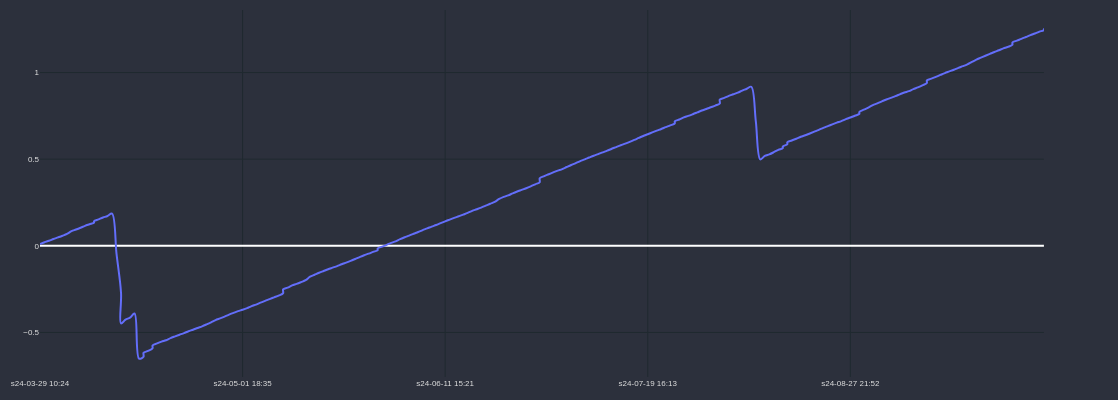

BTCUSDT 68970.0 63327.59 -0.08909876406160418


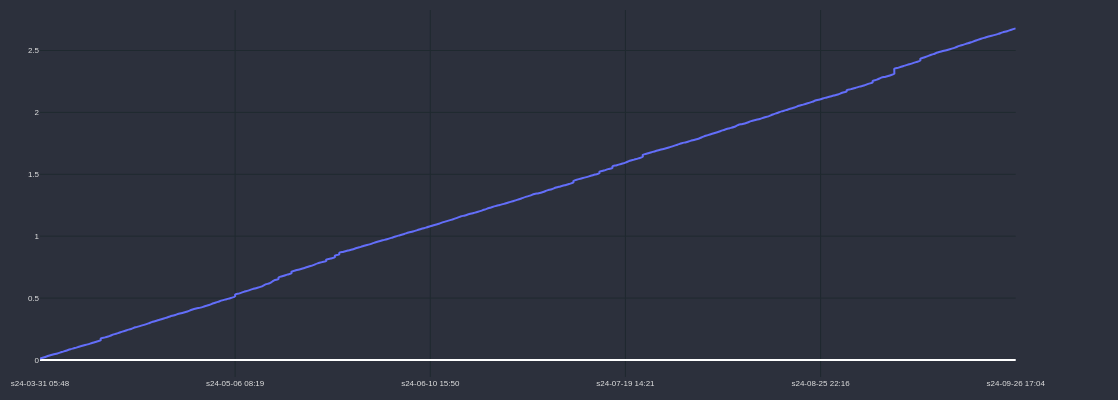

ETHUSDT 3576.78 2602.23 -0.3745057124082038


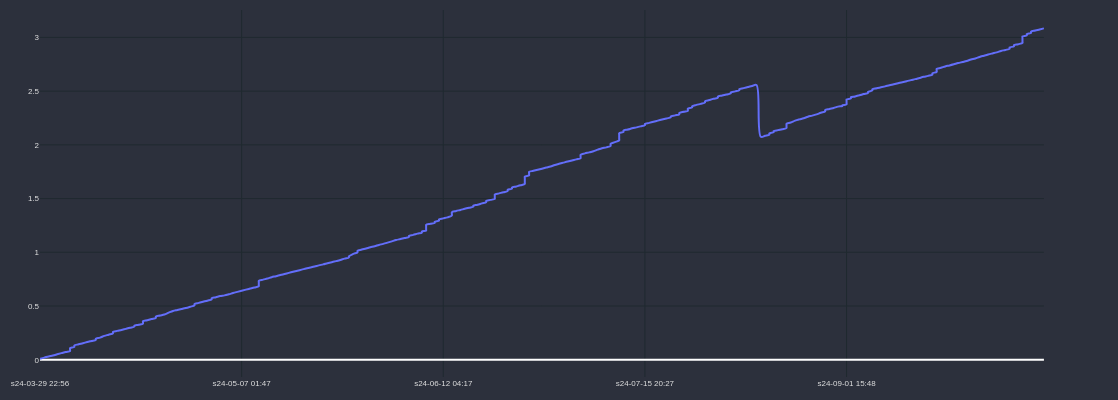

BNBUSDT 584.6 567.4 -0.030313711667254224


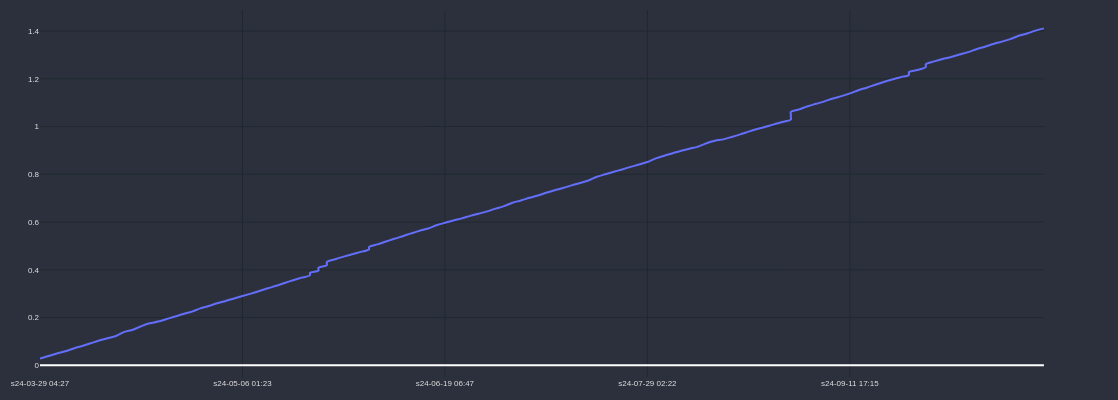

XRPUSDT 0.6124 0.6114 -0.001635590448151784


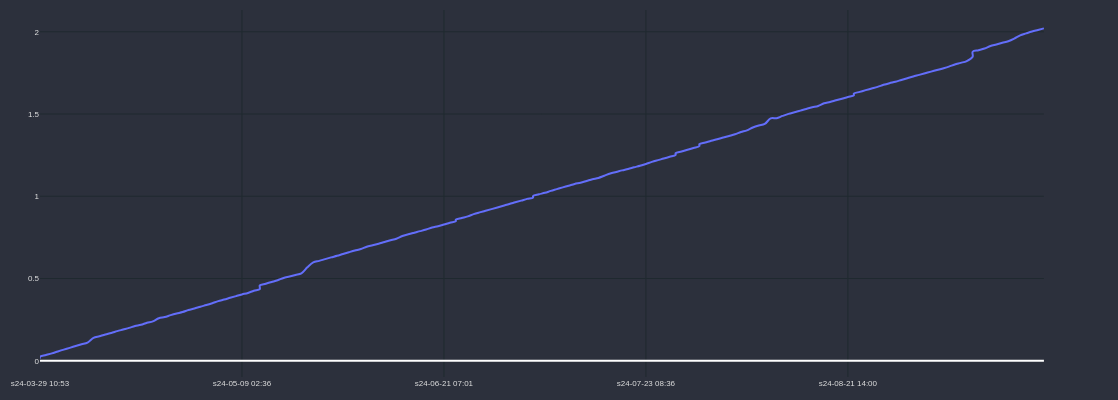

LTCUSDT 95.4 66.82 -0.4277162526189766


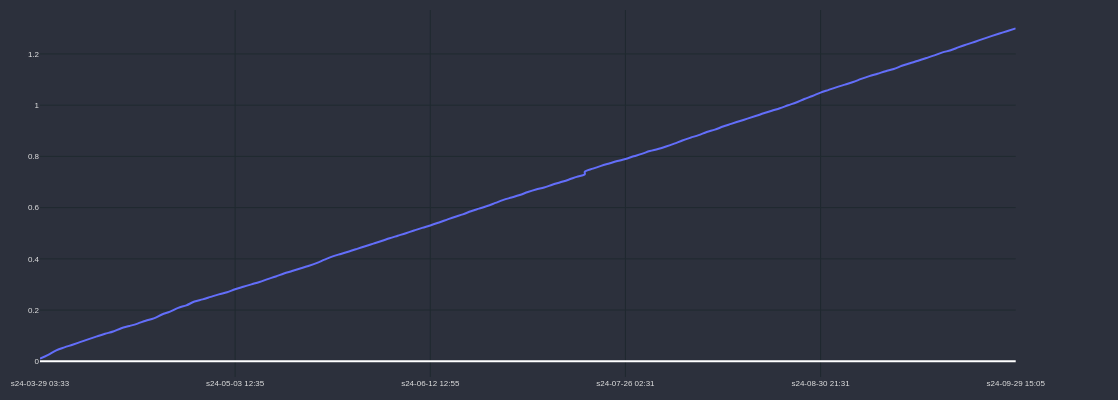

In [154]:
ranks = [rank_ADAUSDT,rank_BTCUSDT, rank_ETHUSDT, rank_BNBUSDT, rank_XRPUSDT, rank_LTCUSDT]

for rank in ranks:
    first_p = rank.iloc[0].first_p
    last_p = rank.iloc[0].last_p
    rel_first_last = (last_p - first_p)/last_p
    print(rank.iloc[0].pair, first_p, last_p, rel_first_last )
    rank.iloc[0].r['time'] = rank.iloc[0].r['end_time']
    rank.iloc[0].r['GAIN_C'] = rank.iloc[0].r.strategy.cumsum()

    cp = CandlePlot(rank.iloc[0].r, candles=False)
    cp.show_plot(line_traces = ['GAIN_C'])

In [78]:

df_up.describe()

,start_index_m5,count,trigger_type,strategy,cstrategy,total_opened,start_price,trigger_price,SIGNAL_UP,SIGNAL_DOWN,result,end_time,start_time,time,GAIN_C
count,4.055000e+03,4055.000000,4055.000000,4055.000000,4055.0,4055.000000,4055.000000,4055.000000,4055.000000,4055.000000,4055.000000,4055,4055,4055,4055.000000
mean,1.672127e+06,21410.138594,2.955117,0.042162,0.0,77.766461,31338.094698,32704.254081,2.955117,0.004439,1366.159383,2022-03-24 11:23:57.573366272,2022-03-09 14:25:45.425400576,2022-03-24 11:23:57.573366272,75.658198
min,8.139000e+03,3.000000,1.000000,-0.316121,0.0,1.000000,3390.610000,3409.470000,1.000000,0.000000,-8168.080000,2019-01-08 02:16:00,2019-01-06 17:18:00,2019-01-08 02:16:00,-0.439366
25%,9.667540e+05,5507.500000,3.000000,-0.015512,0.0,29.000000,13861.980000,15332.240000,3.000000,0.000000,-450.310000,2020-11-05 19:13:30,2020-11-04 06:39:00,2020-11-05 19:13:30,28.417537
50%,1.693360e+06,13854.000000,3.000000,0.098906,0.0,65.000000,28417.710000,29690.170000,3.000000,0.000000,1244.430000,2022-04-23 23:48:00,2022-03-24 19:30:00,2022-04-23 23:48:00,79.988091
75%,2.497301e+06,30192.000000,3.000000,0.101494,0.0,120.000000,43523.045000,44092.790000,3.000000,0.000000,3576.315000,2023-10-20 10:41:00,2023-10-04 03:51:00,2023-10-20 10:41:00,102.820642
max,3.002086e+06,137123.000000,3.000000,0.166736,0.0,246.000000,73527.280000,73582.650000,3.000000,9.000000,7115.180000,2024-09-27 14:36:00,2024-09-18 16:56:00,2024-09-27 14:36:00,170.967148
std,8.564011e+05,22889.388366,0.296265,0.087143,0.0,57.960936,18935.499828,20051.427751,0.296265,0.199852,2944.020864,NaN,NaN,NaN,46.509378


In [81]:

dd = df_up[df_up['strategy']>0]
# ee = dd[dd['strategy']<0]
# ee

In [82]:
ddf = res[0]['res'].df
test = ddf.iloc[66685:66685+906+1]
test


AttributeError: 'DonchianTrend' object has no attribute 'df'

In [28]:
print(test.iloc[0].Close,test.iloc[-1].Close)
print(test.returns.sum())

3620.8 3618.5
-0.0007575267814862174
